<a href="https://colab.research.google.com/github/bicalabs/CogNN/blob/main/CogNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BICA model for unsupervised Hebian cognitive neural network (CogNN)

We aim to create a computationally-efficient neural network which will be able to unsupervisingly learn hidden information from the provided dataset and detect internal correlations between data such that when it will be applied to a novel data set it will be able to reveal that information.

In other words, unlike most of the existing ML models, performing supervised pattern recognition or unsupervised classification, this model will be able to explore "laws" embedded into the data and use them for "understanding" the data  (like "finding gravity law from raw data on ball drops"). This property we define as **cognition** and we plan to use biologically-inspired cognitive architecture (BICA) approach to construct such network.

## Basics of the model

We plan to build upon consepts of *spiking neuronal networks* and *unsupervised Hebian learning* (please read about them in order to unserstand what we are doing here) and use *reductionistic approach*, leaving only mathematical core of the neuronal tissue plasticcity (learning) and information processing from the typical mammals brain cortex. 

In particular, unlike most of spiking NNs, we will use synchronous modeilling of asynchronous neuronal properties. This will be done by "time discretisation", where neuronal output is defined as a number of action potencials in a *spike train*, assuming that the longest spike train still fits the single time step. This allows to represent input for each neuron as an integer number (number of received spikes in a train) and in each model time interval there will be either 0 input or positive-numbered input. The same applies to the output.

Second, no recurrency will be used, so all neurons will be organized into **neuronal layers**.

Third, we will start with the fully connected layers, assuming that sparse connections can be modelled by the weights reduced to zeros (leading that no information passage between neurons is possible).

Since we use unsupervised approach and Hebian learning, this allows us to get rid of cmputationally-expensive gradient decent back propagation, which also fits into the BICA model (thare is no gradient decent differentiation happpens in the brain cortex).

A system with all the referenced properties can be represented with a simple linear algebra model, where we operate with **neuronal layers** and not individual neuron. Each layer is defined by a **weight matrix** (two-dimensional tensor) $\mathrm{W}$ and takes a single **input vector** ($\mathbf{i}$) with the dimension equal to the number of neurons in the layer, and produce a single **output vector** ($\mathbf{o}$) of the same dimension:

$\begin{align} \mathbf{o} = \displaystyle \frac{(\mathbf{i} \times \mathrm{W})^\top - r}{a}, && (1)\end{align}$

where $r$ is the **activation threshold** (unline the *bias* in usual NNs, this is a scalar and applies to all neurons in the layer), $a$ is a parameter defining how the *overshot* in action potential is transformed into a *spike train*, $\times$ is the vector multiplication, $\mathrm{W}$ is a square matrix with $(n; n)$ dimensionality, $n$ is the number of neurons in the layer, $\mathbf{i}$ and $\mathbf{o}$ and horizontal vectors with $n$ elements and $^\top$ is the matrix transpose operation.

Equation (1) can also be represented in form of $\mathbf{o} = A(\mathbf{i} \times \mathrm{W})$, using **activation function** $A$. As it can be seen, unline in usual NNs, our activation function CogNN is linear:

$\begin{align} A = a^{-1}(x - r). && (2) \end{align}$

The simplicity of this math, comparing to other spiking, perceptron and deep learning architectures singnificantly simplifies ability of their hardware implementation (for instance, with FGPAs) and/or creation of neuromorphic hardware earchitectures.

## Hebian learning

To define the learning rules we need to find functions which will lead to the separation of useful and non-useful inputs in the weight matrix phase space. This is done with two functions: decay and gain. The decay function $D(\mathrm{W})$ is applied only to neurons which produced no spikes. It takes weights coefficients and reduces the weights of all inputs for neurons which were not activated. The gain function $G(\mathrm{W}, \mathbf{o})$ increases the weights of all inputs if the neuron was acitve. Thus, the resulting change in layer weight matrix $\mathrm{W}$ on each taining iteration ("time" $t$) is: 

$\displaystyle \frac{\partial{\mathrm{W}}}{\partial{t}} = \begin{cases}D(\mathrm{W}), & \text{for all neurons which produced no output} \\ G(\mathrm{W}, \mathbf{o}), & \text{for activated neurons}\end{cases}$


In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import tensorflow as tf

def decay(weights, decay_rate = 1.2, skew = 4.0):
  weights_prim = tf.sigmoid((weights - 127) / 127 * skew) * 255 / decay_rate
  return weights_prim

def gain(weights, output):
  log2_out = np.log2(output)
  weights_prim = tf.sigmoid(weights / (32 * (8 - log2_out)) - log2_out / 4) * 256
  return weights_prim


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  


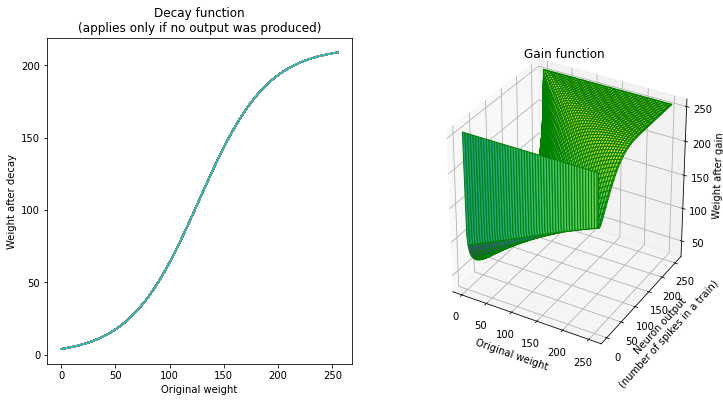

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12, 6))

x = np.outer(np.linspace(0, 255, 100), np.ones(100))
y = decay(x)

ax = fig.add_subplot(1, 2, 1)
ax.plot(x, y)
ax.set_title('Decay function\n(applies only if no output was produced)')
ax.set_xlabel('Original weight')
ax.set_ylabel('Weight after decay')

y = x.copy().T
z = gain(x, y)
  
# syntax for 3-D plotting
ax = fig.add_subplot(1, 2, 2, projection ='3d')
  
# syntax for plotting
ax.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
ax.set_title('Gain function')
ax.set_xlabel('Original weight')
ax.set_ylabel('Neuron output\n(number of spikes in a train)')
ax.set_zlabel('Weight after gain')

plt.show()

> NB: while sigmoids used a lot in the usual neuronal networks as an *activation functions*, it is important to remember that in our case we **do not use any non-linear activation function** and sigmoid here is not an activation function, but part of the *learning function*, helping us to remove the need in differential operations in learning procedure.


### Modelling weigth evolution

Both decay and gain functions are based on sigmoid, which allows faster phase space divergence for the weights in the middle range, and "stabilizes" weight values for the outside boundaries of the range.

Let's see how this happens:


In [5]:
!pip install chaotic-maps # We will use a nice package for visualization of chaotic processes

In [6]:
import chaotic_maps as cm

def decay_map(**kwargs):
  def dynamic(x):
    return decay(x, **kwargs)

  return dynamic

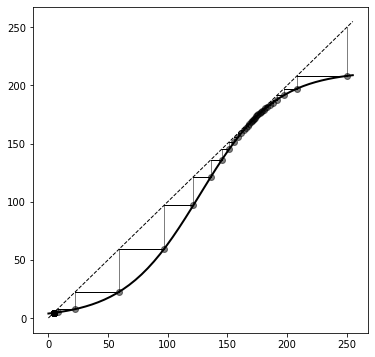

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
cm.cobweb_plot(decay_map(), 250, 50, domain=np.linspace(0, 255), ax=ax)

The above demonstrates so called **coweb diagrams**, which show state evolution of the individual weigth coefficient in time for a non-activated neuron. We call such neurons **apoptotic**, i.e. neuron which never activates and which weigth coefficients decay towards zero, making it permanently silent on any possible input (this mechanism introduces "sparsity" into the neuronal layers).

The weight coefficient starts at value 250 (weights are always in 0..255 range, so they can be represented with a single byte) and  initially quickly degrades towards upper-middle values, where it has a unstable attractor basine. This allows neuron not to "die to early" when it receives a series of inputs which it can't recognize. However, if the neuron remains silent for a longer time, the weigth coefficient leaves the basine and acceletares in its "Decay" towards zero, where it slowers once again, provinding neurone another chance of re-activation; though for now it will take much more activations for the weigth coefficient to restore.

This is an example of how very complex behaviour of dynamic systems may be introduced without the need of non-linear activation functions or differentiation/gradient decent in the learning rules.

The decay functions has two additional parameters, controlling the curvature of sigmoid (named *skew*) and angle of the sigmoid axis (named *decay_rate*), defining the form of the stable weigth regions (*weigth attractor basines*). These parameters may be manipulated by the neural network, such that we can construct quite different learning models utilizing the same underlying CogNN equations.

First, let's these parameters influence our decay process:

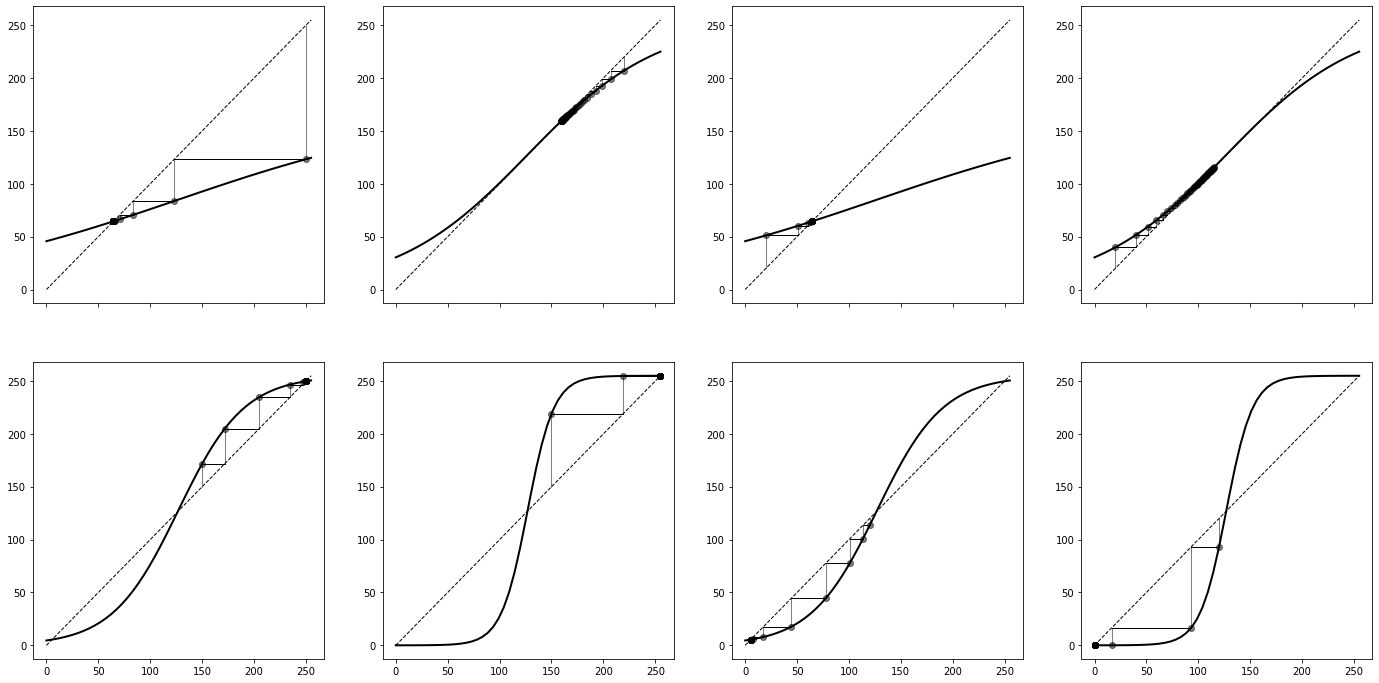

In [8]:
fig, ax = plt.subplots(2, 4, 'all', figsize = (24, 12))
cm.cobweb_plot(decay_map(skew = 1, decay_rate = 1.5), 250, 50, domain=np.linspace(0, 255), ax=ax[0][0])
cm.cobweb_plot(decay_map(skew = 2, decay_rate = 1.), 220, 50, domain=np.linspace(0, 255), ax=ax[0][1])
cm.cobweb_plot(decay_map(skew = 4, decay_rate = 1.), 150, 50, domain=np.linspace(0, 255), ax=ax[1][0])
cm.cobweb_plot(decay_map(skew = 10, decay_rate = 1.), 150, 50, domain=np.linspace(0, 255), ax=ax[1][1])

cm.cobweb_plot(decay_map(skew = 1, decay_rate = 1.5), 20, 50, domain=np.linspace(0, 255), ax=ax[0][2])
cm.cobweb_plot(decay_map(skew = 2, decay_rate = 1.), 20, 50, domain=np.linspace(0, 255), ax=ax[0][3])
cm.cobweb_plot(decay_map(skew = 4, decay_rate = 1.), 120, 50, domain=np.linspace(0, 255), ax=ax[1][2])
cm.cobweb_plot(decay_map(skew = 10, decay_rate = 1.), 120, 50, domain=np.linspace(0, 255), ax=ax[1][3])

As we can see, we may create a set of different attractors in the distinct ranges of possible weigth coefficient values, and also influence the speed of decay (or gain) towards the attractor values.

Let's do the same for the gain function.

In [9]:
import numpy as np
import chaotic_maps as cm

def gain(weight, output):
  log2_out = np.log2(output)
  gain = tf.sigmoid(weight / (32 * (8 - log2_out)) - log2_out / 4) * 256
  return gain

def gain_map(output, **kwargs):
  def dynamic(x):
    return gain(x, output, **kwargs)

  return dynamic

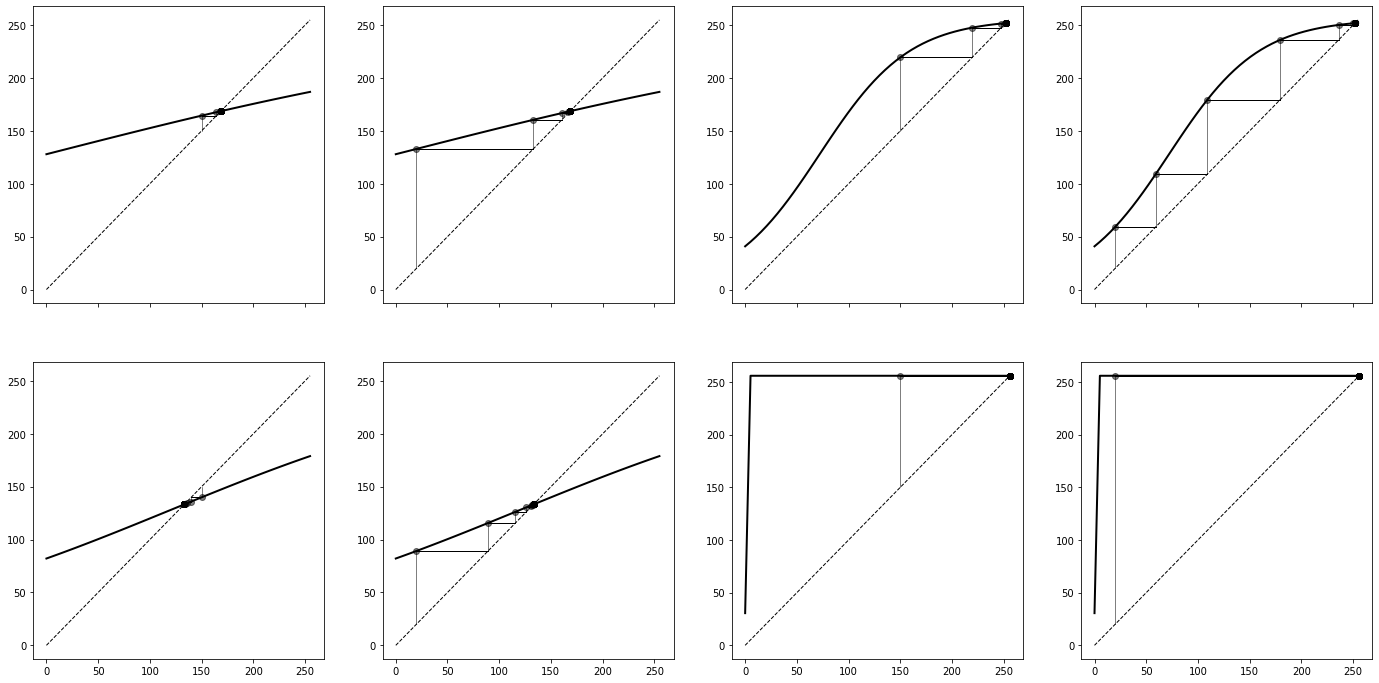

In [10]:
fig, ax = plt.subplots(2, 4, 'all', figsize = (24, 12))

cm.cobweb_plot(gain_map(1.), 150., 50, domain=np.linspace(0, 255), ax=ax[0][0])
cm.cobweb_plot(gain_map(1.), 20., 50, domain=np.linspace(0, 255), ax=ax[0][1])

cm.cobweb_plot(gain_map(8.), 150., 50, domain=np.linspace(0, 255), ax=ax[1][0])
cm.cobweb_plot(gain_map(8.), 20., 50, domain=np.linspace(0, 255), ax=ax[1][1])

cm.cobweb_plot(gain_map(100.), 150., 50, domain=np.linspace(0, 255), ax=ax[0][2])
cm.cobweb_plot(gain_map(100.), 20., 50, domain=np.linspace(0, 255), ax=ax[0][3])

cm.cobweb_plot(gain_map(255.), 150., 50, domain=np.linspace(0, 255), ax=ax[1][2])
cm.cobweb_plot(gain_map(255.), 20., 50, domain=np.linspace(0, 255), ax=ax[1][3])

## Running models

First, we will define a model for CogNN using Tensorflow 2:

In [18]:
import numpy as np
import tensorflow as tf
import math


DEFAULT_THRESHOLD = 10.
DEFAULT_DECAY_RATE = 1.2
DEFAULT_SKEW = 4.


class SpikingLayer(tf.Module):
  def __init__(self, dim, threshold = DEFAULT_THRESHOLD, decay = DEFAULT_DECAY_RATE, skew = DEFAULT_SKEW, **kwargs):
    super().__init__(**kwargs)

    # Storing action potential threshold
    self.threshold = threshold
    # Storing coefficients
    self.decay = decay
    self.skew = skew
    # Storing dimenstionality
    self.dim = dim

    # Initialize layers
    self.weights = tf.Variable(tf.random.uniform((dim, dim), minval = 0., maxval = 255.))
    
  def __call__(self, input, train: bool):
    input = tf.reshape(input, [1, -1])
    output = input @ self.weights / (255. * self.dim)
    print(f'Output run stats: min {np.min(output)}, max {np.max(output)}, mean {np.mean(output)}, median {np.median(output)}')
    output = tf.clip_by_value(output - self.threshold, 0, 255. - self.threshold) * 255 / self.threshold
    if train:
      output_ext = output + tf.constant(0.0, shape = (self.dim, self.dim))
      map = tf.clip_by_value(output_ext, 0, 1)
      self.weights = decay(self.weights, self.decay, self.skew) * (1 - map) + gain(self.weights, output_ext) * map
    return output


class HebianNet(tf.Module):
  def __init__(self, dim, layer_count, threshold = DEFAULT_THRESHOLD, decay = DEFAULT_DECAY_RATE, skew = DEFAULT_SKEW, seed = 2613546, **kwargs):
    super().__init__(**kwargs)

    # Initialize seed for better determinism
    self.seed = seed
    tf.random.set_seed(seed)
    
    # Storing action potential threshold
    self.threshold = threshold
    # Storing coefficients
    self.decay = decay
    self.skew = skew
    # Storing dimenstionality
    self.dim = dim

    self.layers = []
    self.layer_count = layer_count
    for layer_no in range(0, layer_count):
      self.layers.append(SpikingLayer(dim, threshold, decay, skew, **kwargs))

  def __call__(self, input, train: bool):
    input = tf.cast(input, tf.float32)
    for layer in self.layers:
      output = layer(input, train)
      input = output
    output = tf.reshape(output, [-1])
    return output


Now, let's define a component which will help us in visualizing the training and inference

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

class MnistModel:
  def __init__(self, layer_count, threshold, decay = DEFAULT_DECAY_RATE, skew = DEFAULT_SKEW):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    data = tf.reshape(x_train, (-1, 28 * 28))
    self.inputs = tf.random.shuffle(data)

    self.layer_count = layer_count

    self.cognn = HebianNet(
        dim = 28 * 28, 
        layer_count = layer_count, 
        threshold = threshold, 
        decay = decay, 
        skew = skew
    )

    self.display_parameters( 
        interpolation = 'nearest', 
        cmap = 'gray', 
        vmin = 0,
        vmax = 255,
    )


  def train(self, sample_size = 100):
    self.sample_size = sample_size
    self.fig1 = plt.figure(figsize = (32, 12*4))
    if self.layer_count > 1:
      self.fig2 = plt.figure(figsize = (32, 12*4))

    chart_no = 1
    self.outputs = []
    for no in range(0, sample_size):
      # Visualizing weight coefficients
      if no % (sample_size / 10) == 0:
        self.display_weights(chart_no, no)
        chart_no += 1

      output = self.cognn(self.inputs[no], True)
      self.outputs.append(output)

    self.display_inout()
    return self.outputs


  def display_parameters(self, **kwargs):
    self.plot_kwargs = kwargs


  def display_weights(self, chart_no, samples):
    self.display_layer(self.fig1, chart_no, samples, 0)
    layer = self.layer_count - 1
    if layer > 0:
      self.display_layer(self.fig2, chart_no, samples, layer)

  def display_layer(self, fig, chart_no, samples, layer_no):
    weights = self.cognn.layers[layer_no].weights
    ax = fig.add_subplot(4, 3, chart_no)
    img = ax.imshow(weights, **self.plot_kwargs)
    ax.set_title(f'Layer {layer_no + 1}, {samples} samples')
    ax.set_xlabel(f'min: {np.min(weights)}, max: {np.max(weights)}')
    plt.colorbar(img, ax=ax)

  def display_inout(self):
    fig = plt.figure(figsize = (32, 6))
    ax = fig.add_subplot(2, 2, 1)
    a = ax.imshow(self.inputs[:self.sample_size], **self.plot_kwargs)
    ax.set_title('Inputs')

    ax = fig.add_subplot(2, 2, 2)
    b = ax.imshow(self.outputs, **self.plot_kwargs)
    ax.set_title('Outputs')
    plt.colorbar(b, ax=ax)

    ax = fig.add_subplot(2, 2, 4)
    c = ax.imshow(self.outputs)
    ax.set_title('Outputs')
    plt.colorbar(c, ax=ax)


With it we will try to run our first attempt for unsupervised learning from MNIST data:

Output run stats: min 13.640644073486328, max 18.86658477783203, mean 16.5523738861084, median 16.59221649169922
Output run stats: min 7.926565170288086, max 15.283384323120117, mean 12.285847663879395, median 12.228848457336426
Output run stats: min 7.902105331420898, max 18.15773582458496, mean 12.569493293762207, median 12.482646942138672
Output run stats: min 7.641499042510986, max 22.817018508911133, mean 12.3049955368042, median 11.944816589355469
Output run stats: min 3.622786283493042, max 18.752193450927734, mean 6.284416198730469, median 5.879612445831299
Output run stats: min 2.566621780395508, max 15.96584415435791, mean 5.049219131469727, median 4.673513412475586
Output run stats: min 3.6659178733825684, max 20.37641716003418, mean 7.342983722686768, median 6.955121994018555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """


Output run stats: min 1.39811110496521, max 14.112879753112793, mean 3.798860549926758, median 3.613490581512451
Output run stats: min 2.998783826828003, max 26.957658767700195, mean 7.691028594970703, median 7.331933498382568
Output run stats: min 3.143557071685791, max 38.526771545410156, mean 8.493520736694336, median 8.005452156066895
Output run stats: min 2.5911530698863317e-08, max 45.576385498046875, mean 9.059240341186523, median 9.017526626586914
Output run stats: min 5.745948964026859e-13, max 37.70980453491211, mean 7.077640533447266, median 7.020214557647705
Output run stats: min 4.26506607809074e-09, max 8.267668724060059, mean 2.0631375312805176, median 2.0533742904663086
Output run stats: min 0.49729809165000916, max 20.583438873291016, mean 5.598707675933838, median 5.709540367126465
Output run stats: min 0.37286177277565, max 18.234621047973633, mean 3.559124708175659, median 3.644120216369629
Output run stats: min 0.6042489409446716, max 28.938995361328125, mean 5.477

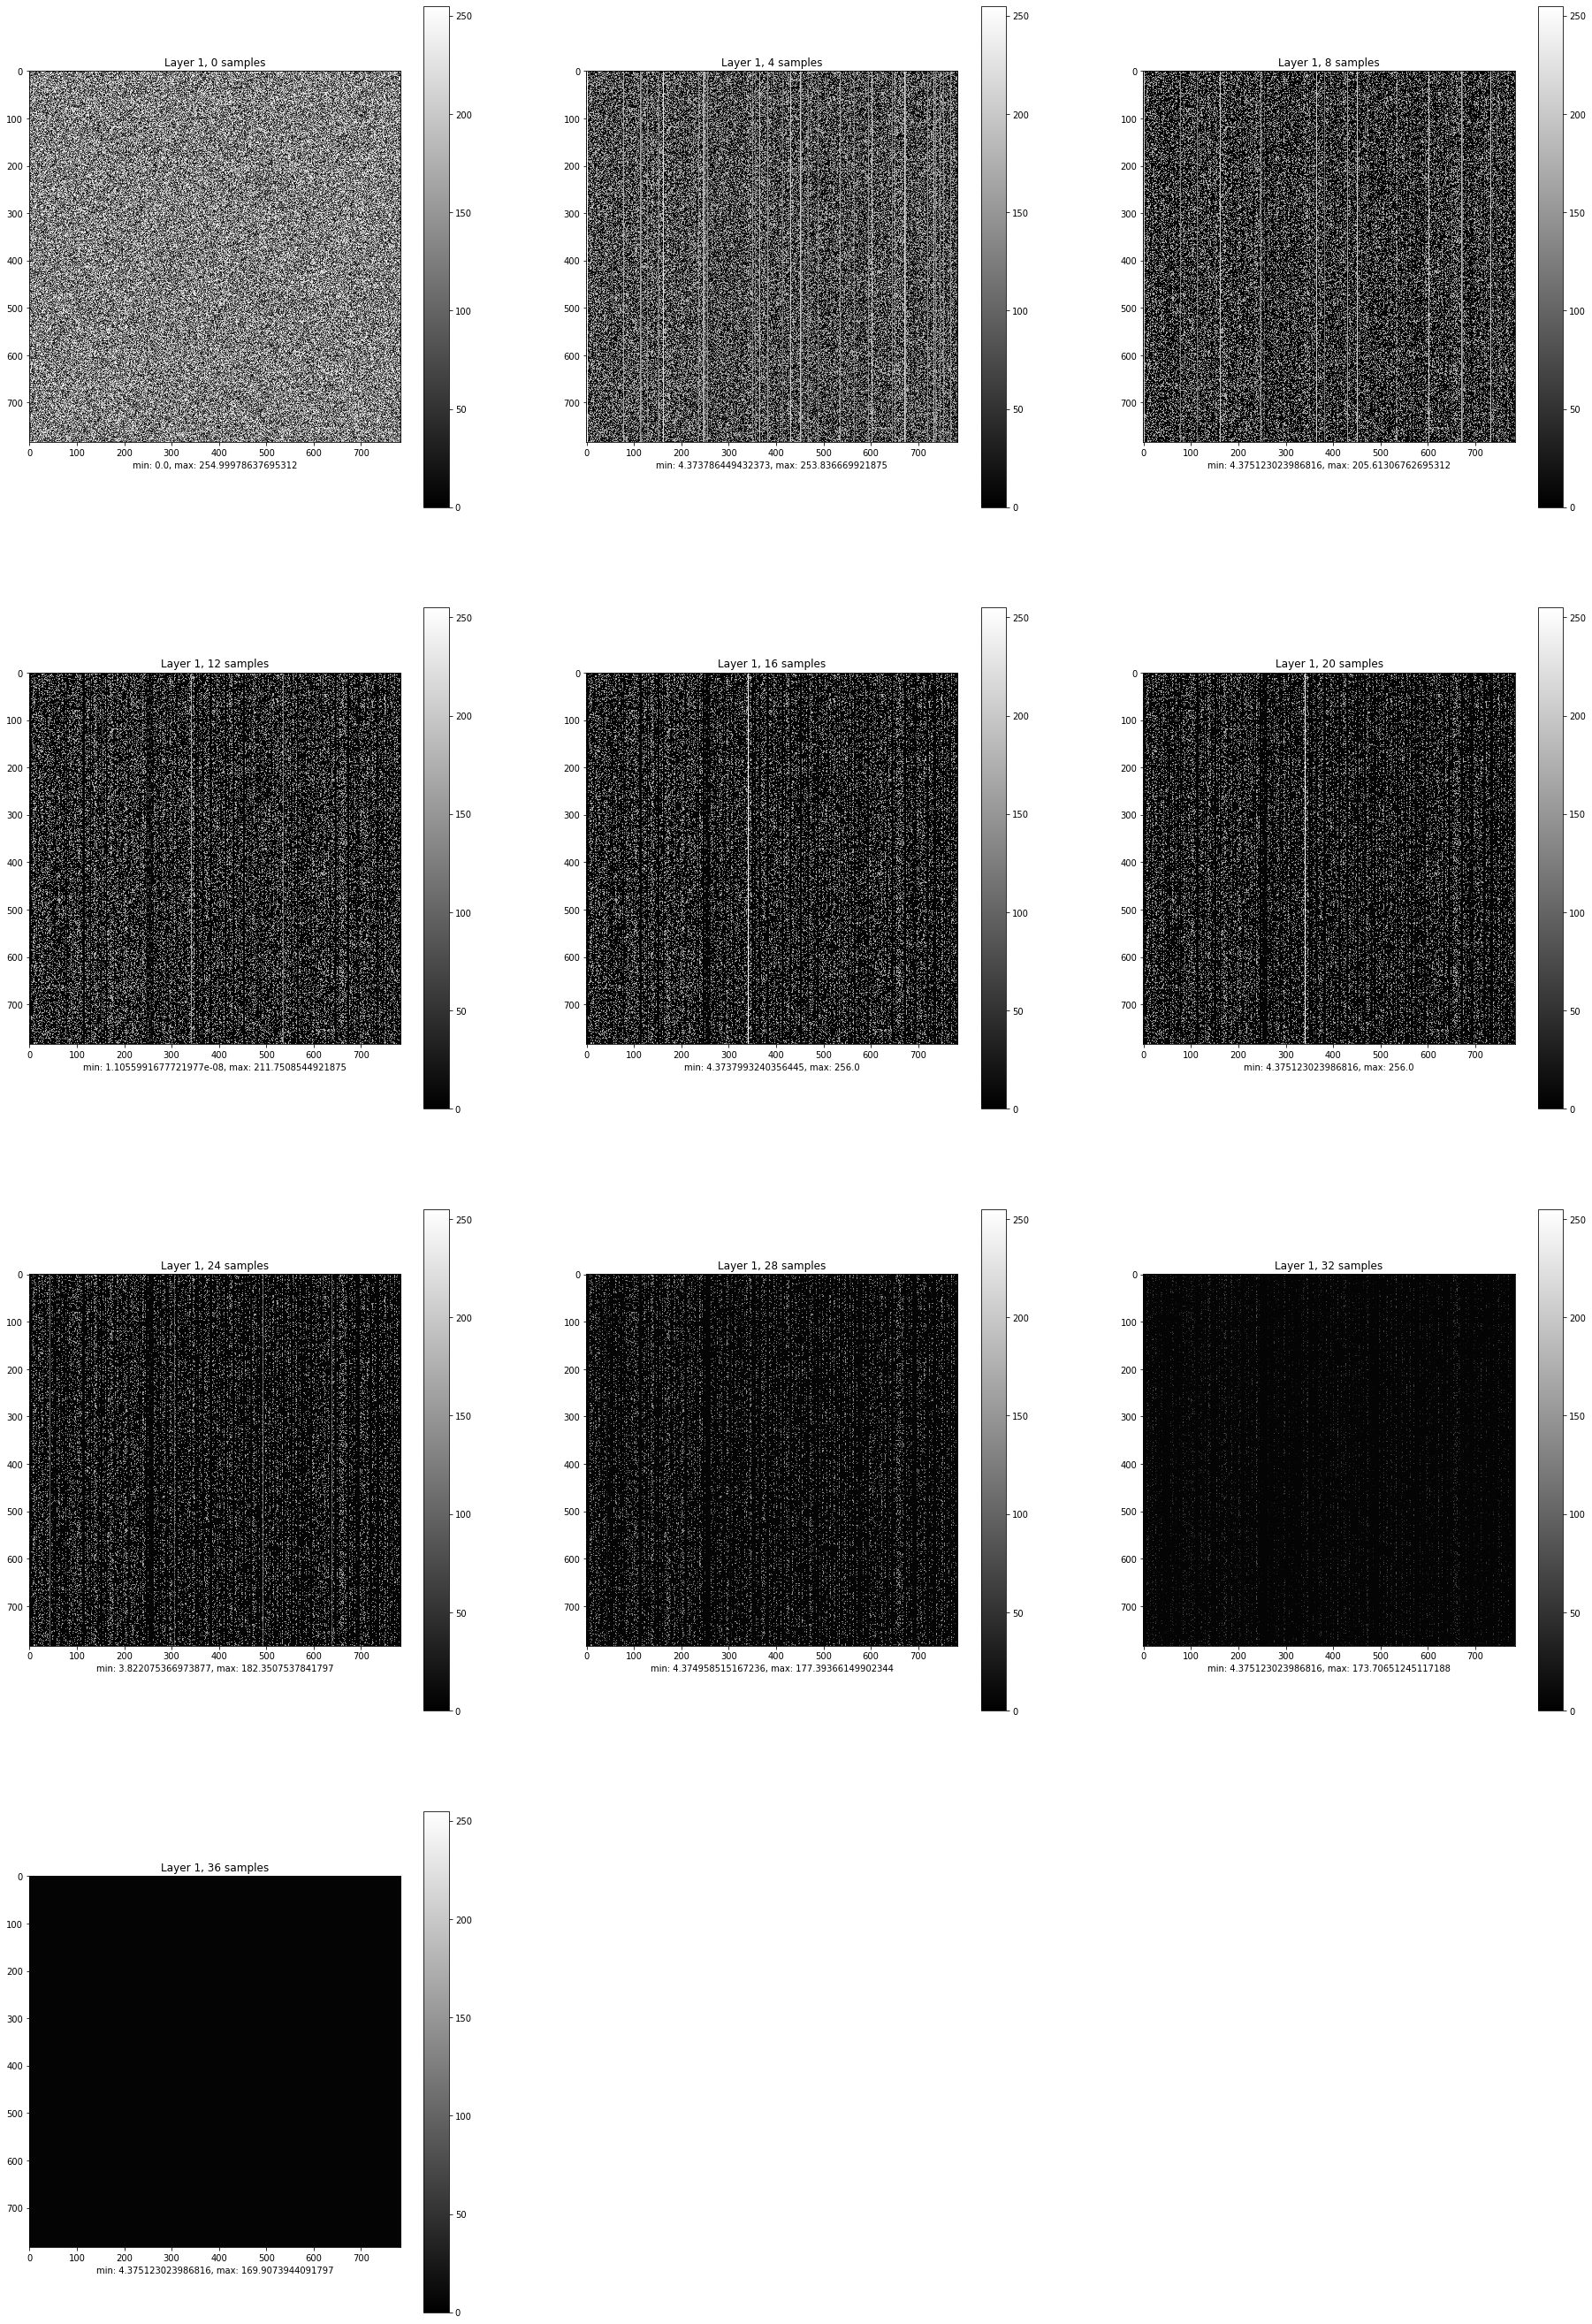

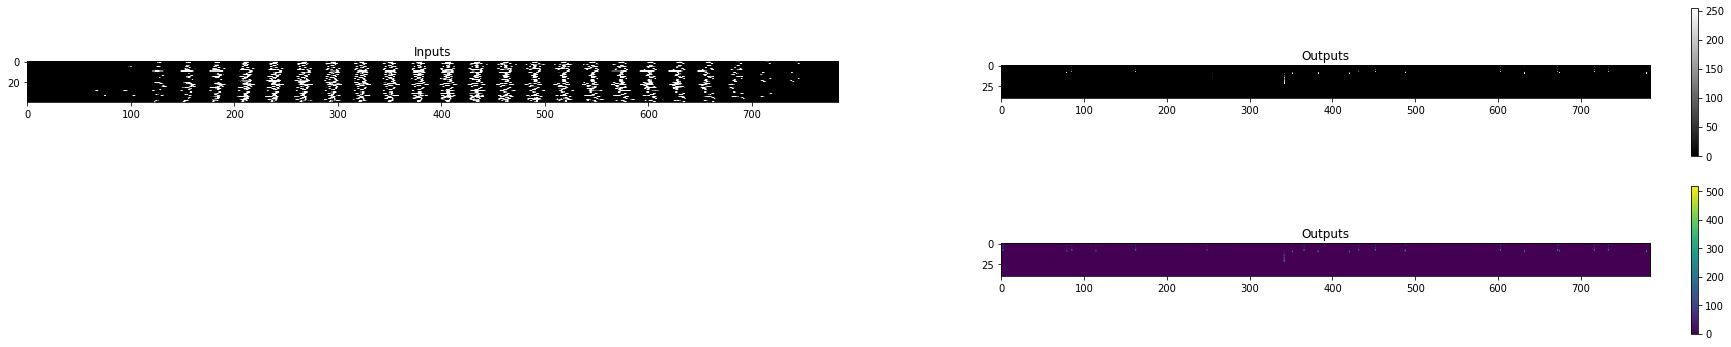

In [21]:
model = MnistModel(layer_count = 1, threshold = 15)

outputs = model.train(sample_size = 40)
weights = model.cognn.layers[0].weights

print(f'Inputs min: {np.min(model.inputs)}, max: {np.max(model.inputs)}')
print(f'Outputs min: {np.min(outputs)}, max: {np.max(outputs)}')
print(f'Weights min: {np.min(weights)}, max: {np.max(weights)}')
